# Imports

In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [13]:
!pip install meteostat

In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
import glob
import time
import numpy as np
import pandas as pd
from geopy.distance import distance
import datetime as datetime
from multiprocessing import Process, Manager
from sklearn.preprocessing import MinMaxScaler
import holidays
us_holidays = holidays.country_holidays('US')

# Read CSV

In [ ]:
raw_data = pd.DataFrame()

import glob
directory = '/content/drive/MyDrive/Thesis'
data_dir = directory + "/Data/Baywheels"


csv_files = glob.glob(f"{data_dir}/*.csv")

for csv in csv_files:
  raw_data = pd.concat([raw_data, pd.read_csv(csv)])

In [6]:
raw_data = raw_data.dropna(subset=[
    'start_lat',
    'start_lng',
    'end_lat',
    'end_lng'])

raw_data['started_at'] = pd.to_datetime(raw_data['started_at'])
raw_data['ended_at'] = pd.to_datetime(raw_data['ended_at'])
raw_data['duration_sec'] = (raw_data['ended_at'] - raw_data['started_at'])/ pd.Timedelta(seconds=1)


In [11]:
raw_data

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,62F9541E3A674E42,electric_bike,2022-12-24 03:45:23,2022-12-24 03:58:14,1st St at Folsom St,SF-G29-2,Harrison St at 20th St,SF-P24,37.787228,-122.394307,37.758862,-122.412544,member
1,50064BD2000D8D23,electric_bike,2022-12-07 08:53:20,2022-12-07 09:06:28,Valencia St at 21st St,SF-P22,Powell St BART Station (Market St at 4th St),SF-G27,37.756719,-122.421203,37.786138,-122.405234,member
2,1D225DE9CC6274EE,classic_bike,2022-12-11 11:07:31,2022-12-11 11:55:19,40th St at Piedmont Ave,OK-F6,Grand Ave at Perkins St,OK-I8,37.825785,-122.253470,37.808894,-122.256460,casual
3,933BB68D7C61E42A,electric_bike,2022-12-09 13:46:29,2022-12-09 13:51:08,Mission Playground,SF-O22,24th St at Chattanooga St,SF-Q21-2,37.759241,-122.421483,37.751819,-122.426614,casual
4,CF73C4A15A9B8A4A,electric_bike,2022-12-06 16:23:55,2022-12-06 16:29:47,NaN,NaN,MacArthur Ave at Fernandez St,SF-C14,37.800000,-122.440000,37.796593,-122.455688,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
251465,54702DAC24EDECE2,electric_bike,2024-03-17 17:38:14,2024-03-17 17:39:27,Francisco St at Columbus Ave,SF-A24-2,Francisco St at Columbus Ave,SF-A24-2,37.804497,-122.415712,37.804454,-122.415794,casual
251466,B79925A4CF3BA583,electric_bike,2024-03-17 17:45:53,2024-03-17 17:46:52,Francisco St at Columbus Ave,SF-A24-2,Francisco St at Columbus Ave,SF-A24-2,37.804412,-122.415789,37.804454,-122.415794,casual
251467,90087D7FBECB07A7,electric_bike,2024-03-15 21:19:58,2024-03-15 21:35:57,Montgomery St BART Station (Market St at 2nd St),SF-F28-2,Montgomery St BART Station (Market St at 2nd St),SF-F28-2,37.789913,-122.400833,37.789620,-122.400808,casual
251468,E4AB7E2A03FA064C,electric_bike,2024-03-16 16:32:48,2024-03-16 16:46:35,Montgomery St BART Station (Market St at 2nd St),SF-F28-2,Montgomery St BART Station (Market St at 2nd St),SF-F28-2,37.789876,-122.400684,37.789620,-122.400808,casual


# Finding Standard Stations

In [ ]:
start_stations = raw_data[["start_station_id",
                             'start_lat',
                             "start_lng"]]\
.sort_values(['start_lat', "start_lng"])\
.drop_duplicates(subset=['start_lat','start_lng'])\
.dropna().drop_duplicates(subset=['start_station_id'])\
.query("start_lat != 0").reset_index(drop=True).rename(
    columns={
        "start_station_id": "station_id",
        'start_lat': "station_latitude",
        "start_lng": "station_longitude"
  })

end_stations = raw_data[["end_station_id",
                           'end_lat',
                           "end_lng"]]\
.sort_values(['end_lat', "end_lng"])\
.drop_duplicates(subset=['end_lat','end_lng'])\
.dropna().drop_duplicates(subset=['end_station_id'])\
.query("end_lat != 0").reset_index(drop=True).rename(
    columns={"end_station_id": "station_id",
            'end_lat': "station_latitude",
            "end_lng": "station_longitude"
        })

In [ ]:
standard_stations = pd.concat([start_stations, end_stations]).sort_values(
    ['station_latitude', "station_longitude"]).drop_duplicates(subset=['station_id'])

# Approximate Station

In [ ]:
def calculate_geodesic_distance(df_stations, point):
    df = df_stations.copy()
    for idx, i, j  in zip(df.index, df.station_latitude, df.station_longitude):
        df.loc[idx, 'distance'] = distance(point, (i,j)).m
        if int(df.loc[idx, 'distance']) == 0:

            return df.loc[idx, "station_id"], df.loc[idx, 'distance']
    df = df.sort_values("distance")
    return df.iloc[0]["station_id"], df.iloc[0]["distance"]

In [ ]:
def get_approximate_stations_locations(df_missing_stations, start_stations, col="start"):

    for idx, i, j in zip(df_missing_stations.index,
                         df_missing_stations[f'{col}_lat'],
                         df_missing_stations[f'{col}_lng']):

        approx_station, approx_distance = calculate_geodesic_distance(start_stations,
                            (i, j))
        df_missing_stations.loc[idx,f"{col}_approx"] = approx_station
        df_missing_stations.loc[idx,f"{col}_approx_distance"] = approx_distance


    return df_missing_stations

In [ ]:

df_missing_stations = raw_data[(raw_data['start_station_id'].isna()) |\
                                (raw_data['end_station_id'].isna())].copy()

df_existing_stations = raw_data[~((raw_data['start_station_id'].isna()) |\
                                    (raw_data['end_station_id'].isna()))].copy()

df_missing_start_stations_no_duplicates = df_missing_stations.drop_duplicates(
                                        subset=['start_lat', 'start_lng']).copy()\
                                            .reset_index(drop=True)
df_missing_start_stations_no_duplicates = df_missing_start_stations_no_duplicates[
                                            df_missing_start_stations_no_duplicates['start_station_id'].isna()].copy()\
                                            .reset_index(drop=True)

df_missing_end_stations_no_duplicates = df_missing_stations.drop_duplicates(
                                        subset=['end_lat', 'end_lng']).copy()\
                                            .reset_index(drop=True)
df_missing_end_stations_no_duplicates = df_missing_end_stations_no_duplicates[
                                            df_missing_end_stations_no_duplicates['end_station_id'].isna()].copy()\
                                                .reset_index(drop=True)

In [ ]:
approximate_start_stations_df = get_approximate_stations_locations(df_missing_start_stations_no_duplicates,
                                   standard_stations.reset_index(drop=True).copy(),
                                            col ="start")

In [ ]:
approximate_end_stations_df = get_approximate_stations_locations(df_missing_end_stations_no_duplicates,
                                   standard_stations.reset_index(drop=True).copy(),
                                         col ="end")

In [ ]:
df_missing_stations = df_missing_stations.merge(
    approximate_start_stations_df[["start_approx",
                             'start_lat',
                             'start_lng',
                             'start_approx_distance']],
    on=['start_lat',
        'start_lng'], how="left")

In [ ]:
df_missing_stations = df_missing_stations.merge(
    approximate_end_stations_df[["end_approx",
                             'end_lat',
                             'end_lng',
                             'end_approx_distance']],
    on=['end_lat',
        'end_lng'], how="left")

In [ ]:
index = df_missing_stations['start_approx_distance'] < 500
df_missing_stations.loc[index, 'start_station_id'] = df_missing_stations.loc[index, 'start_approx']

index = df_missing_stations['end_approx_distance'] < 500
df_missing_stations.loc[index, 'end_station_id'] = df_missing_stations.loc[index, 'end_approx']

In [ ]:
df_completed_stations = df_missing_stations.dropna(subset=['start_station_id', 'end_station_id'])

In [ ]:
df_existing_stations = df_existing_stations.drop(columns=['start_station_name', 'end_station_name'])
df_completed_stations = df_completed_stations.drop(columns=['start_station_name', 'end_station_name'])
df = pd.concat([df_completed_stations, df_existing_stations]).copy()
#df.to_csv("baywheels_confirmed_stations.csv")

In [ ]:
del raw_data

# Dropping Trips < X minutes duration, where start = end

X = 4

In [ ]:
minutes = 4
minutes_not_same = 2

df_same_station = df[(df['start_station_id'] == df['end_station_id']) &
                     (df['duration_sec'] > minutes*60)]


df_no_same_station = df[(df['start_station_id'] != df['end_station_id']) &
                     (df['duration_sec'] > minutes_not_same*60)]

df_final = pd.concat([df_no_same_station, df_same_station]).reset_index(drop=True)

In [ ]:
del df_no_same_station
del df_same_station

# Change Types

In [ ]:
df = df_final.dropna(subset=['start_station_id', 'end_station_id']).drop(['rideable_type', 'member_casual', 'start_approx',	'start_approx_distance',	'end_approx',	'end_approx_distance'], axis=1)
#df['start_station_id'] = pd.to_numeric(df['start_station_id'])
#df['end_station_id'] = pd.to_numeric(df['end_station_id'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['started_at'] = pd.to_datetime(df['started_at'])

df.dtypes

ride_id                     object
started_at          datetime64[ns]
ended_at            datetime64[ns]
start_station_id            object
end_station_id              object
start_lat                  float64
start_lng                  float64
end_lat                    float64
end_lng                    float64
duration_sec               float64
dtype: object

# Add Weather data

In [ ]:
import geopandas as gp
import datetime as datetime
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import DBSCAN
from meteostat import Point, Hourly
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import haversine_distances


In [ ]:
points_in_radians = standard_stations[['station_latitude','station_longitude']].apply(np.radians).values
distances_in_km = haversine_distances(points_in_radians) * 6371

In [ ]:
distance_matrix = distances_in_km

clustering_areas = DBSCAN(eps= 0.1, min_samples=20)
clustering_stations = DBSCAN(eps= 0.0045, min_samples=1)
scaler = MinMaxScaler()
df_temp = standard_stations.copy()
df_temp[['station_latitude', 'station_longitude']] = \
                            scaler.fit_transform(df_temp[['station_latitude', 'station_longitude']])
clusters_areas = clustering_areas.fit_predict(df_temp[['station_latitude', 'station_longitude']])

clusters_stations = clustering_stations.fit_predict(df_temp[['station_latitude', 'station_longitude']])

In [ ]:
del df_temp

In [ ]:
standard_stations['clusters'] = clusters_areas
standard_stations['cluster_stations'] = clusters_stations

centroids = standard_stations.groupby("clusters")[['station_latitude', 'station_longitude']].mean()
centroids = centroids.reset_index().rename(columns={
    "station_latitude": "station_latitude_centroid",
    "station_longitude": "station_longitude_centroid",
})

centroid_stations = standard_stations.groupby("cluster_stations")[['station_latitude', 'station_longitude']].mean()
centroid_stations = centroid_stations.reset_index().rename(columns={
    "station_latitude": "station_latitude_centroid_stations",
    "station_longitude": "station_longitude_centroid_stations",
})

In [ ]:
standard_stations = standard_stations.merge(centroid_stations, on=['cluster_stations'], how="left")

In [ ]:
cluster_weather_dict = {}
station_weather_dict = {}

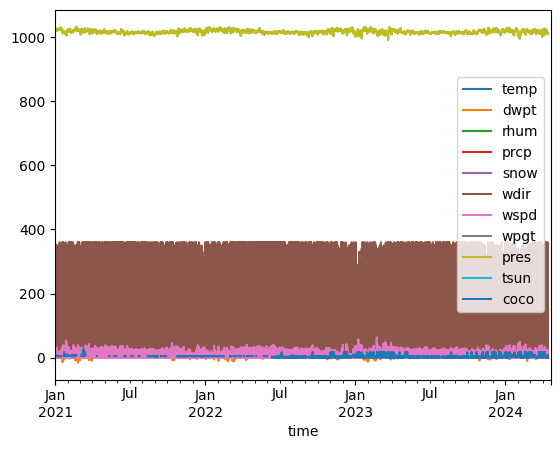

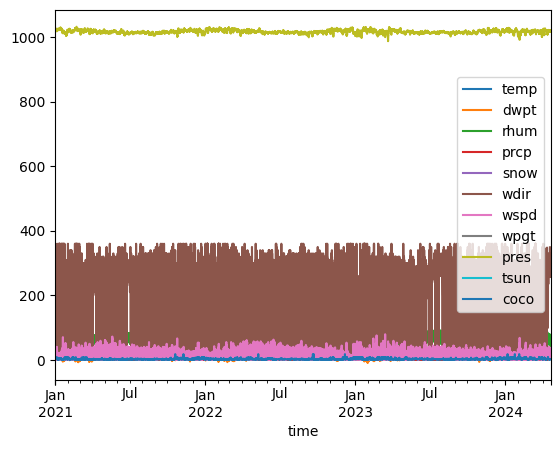

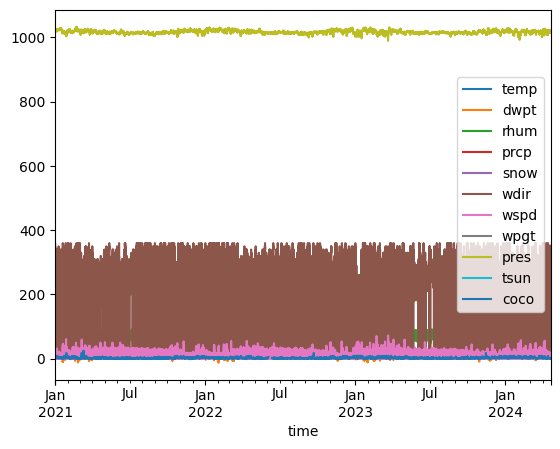

In [ ]:
start = datetime.datetime(2020, 12, 31)
end = datetime.datetime(2024, 5, 1)

for ii in centroids.index:


    # Create Point for Vancouver, BC
    location = Point(centroids.loc[ii]['station_latitude_centroid'],
                     centroids.loc[ii]['station_longitude_centroid'])
    # Get daily data for 2018
    data = Hourly(location, start, end)
    data = data.fetch()
    cluster_weather_dict[centroids.loc[ii]['clusters']] = data
    # Plot line chart including average, minimum and maximum temperature
    data.plot(y=['temp', 'dwpt', 'rhum', 'prcp', 'snow',
                 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco'])


In [ ]:
weather_data = pd.DataFrame()

for ii in cluster_weather_dict:
    cluster_weather_dict[ii] = cluster_weather_dict[ii].interpolate()
    cluster_weather_dict[ii]['centroid'] = ii

    weather_data = pd.concat([weather_data, cluster_weather_dict[ii]])

In [ ]:
centroid_stations

,cluster_stations,station_latitude_centroid_stations,station_longitude_centroid_stations
0,0,37.278118,-121.825770
1,1,37.302419,-121.868460
2,2,37.306075,-121.857710
3,3,37.308742,-121.900190
4,4,37.310628,-121.895369
...,...,...,...
321,321,37.873016,-122.267467
322,322,37.873558,-122.283093
323,323,37.875112,-122.260553
324,324,37.876573,-122.269528


In [ ]:
fig = px.scatter_mapbox(standard_stations, lat='station_latitude', lon='station_longitude',
                        color = "clusters",
                        mapbox_style="open-street-map",
                        hover_name="station_id",
                       )

fig.add_trace(go.Scattermapbox(
        lat=centroids['station_latitude_centroid'],
        lon=centroids['station_longitude_centroid'],
        mode='markers',
        hoverinfo='text',
        name="Cluster Centroids",
        marker=go.scattermapbox.Marker(
            size=15,
            color='rgb(0, 0, 0)',
            opacity=0.7
        ),
    ))

fig.update_geos(fitbounds="locations")
fig.show()

In [ ]:
fig = px.scatter_mapbox(standard_stations, lat='station_latitude', lon='station_longitude',
                        color = "cluster_stations",
                        mapbox_style="open-street-map",
                        hover_name="station_id",
                       )

fig.add_trace(go.Scattermapbox(
        lat=centroid_stations['station_latitude_centroid_stations'],
        lon=centroid_stations['station_longitude_centroid_stations'],
        mode='markers',
        hoverinfo='text',
        name="Cluster Centroids",
        marker=go.scattermapbox.Marker(
            size=15,
            color='rgb(0, 0, 0)',
            opacity=0.7
        ),
    ))

fig.update_geos(fitbounds="locations")
fig.show()

# Final DF

In [ ]:
def create_datetime_features(input_df, column_name):

    input_df[column_name+'_hour'] = input_df[column_name].dt.hour
    input_df[column_name+'_minute'] = input_df[column_name].dt.minute
    input_df[column_name+'_quarter'] = input_df[column_name].dt.quarter
    input_df[column_name+'_month'] = input_df[column_name].dt.month
    input_df[column_name+'_year'] = input_df[column_name].dt.year
    input_df[column_name+'_week'] = input_df[column_name].dt.isocalendar().week
    input_df[column_name+'_day'] = input_df[column_name].dt.day
    input_df[column_name+'_dayofweek'] = input_df[column_name].dt.dayofweek

    return input_df

In [ ]:
df = df.merge(
    standard_stations.rename(columns={
        "station_id": 'start_station_id'
    }), on= 'start_station_id'
)

df['start_lat'] = df['station_latitude']
df['start_lng'] = df['station_longitude']
df['start_station_cluster'] = df['clusters']

df = df.drop(columns=['station_latitude', 'station_longitude', 'clusters', 'cluster_stations'])
df = df.merge(
    standard_stations.rename(columns={
        "station_id": 'end_station_id'
    }), on= 'end_station_id'
)

df['end_lat'] = df['station_latitude']
df['end_lng'] = df['station_longitude']
df['end_station_cluster'] = df['clusters']
df = df.drop(columns=['station_latitude', 'station_longitude', 'clusters', 'cluster_stations'])

In [ ]:
df = create_datetime_features(df, 'started_at')
df = create_datetime_features(df, 'ended_at')

In [ ]:
from sklearn.utils.extmath import cartesian
from geopy.distance import geodesic

# Get all possible start locations and their geo info
subset = ["start_lng", "start_lat", "start_station_id"]
all_starts = df.drop_duplicates(subset="start_station_id", keep="first")[subset]
# Get all possible end locations and their geo info
subset = ["end_lng", "end_lat", "end_station_id"]
all_ends = df.drop_duplicates(subset="end_station_id", keep="first")[subset]
# Combine all combinations in one dataframe
distance_matrix = all_ends.merge(all_starts, how="cross")
distance_matrix["distance"] = distance_matrix.apply(lambda x: geodesic((x["start_lat"], x["start_lng"]),
                                                          (x["start_lat"], x["end_lng"])).meters, axis=1)
distance_matrix.head()

,end_lng,end_lat,end_station_id,start_lng,start_lat,start_station_id,distance
0,-122.419238,37.760514,SF-I21,-122.412562,37.758882,SF-J29-1,588.332053
1,-122.419238,37.760514,SF-I21,-122.408375,37.772361,SF-C25,957.098984
2,-122.419238,37.760514,SF-I21,-122.419238,37.760514,SF-I21,0.000000
3,-122.419238,37.760514,SF-I21,-122.421813,37.769996,SF-J14,226.898693
4,-122.419238,37.760514,SF-I21,-122.478011,37.778405,SF-G8-1,5177.653251


In [ ]:
le = LabelEncoder()

le.fit(standard_stations['station_id'])

import pickle
with open('/content/drive/MyDrive/Colab Notebooks/GBDS_Project/raw_data/station_encoder.pkl', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [ ]:
distance_matrix.to_csv("/content/drive/MyDrive/Colab Notebooks/GBDS_Project/processed_data/distance_matrix.csv")

In [ ]:
standard_stations.to_csv("/content/drive/MyDrive/Colab Notebooks/GBDS_Project/processed_data/standard_stations.csv")#.info()

In [ ]:
weather_data_time = weather_data.reset_index().rename(columns={
    "time": "started_at_hourly"
})

In [ ]:
column_name='started_at'
conversion_dict_hourly = dict(year= df[f'{column_name}_year'],
                              month=df[f'{column_name}_month'],
                              day=  df[f'{column_name}_day'],
                              hour= df[f'{column_name}_hour']
                              )

df[f'{column_name}_hourly'] = pd.to_datetime(conversion_dict_hourly)

In [ ]:
df[f'{column_name}_hourly']

0         2021-01-26 11:00:00
1         2021-01-26 15:00:00
2         2021-01-21 14:00:00
3         2021-01-31 12:00:00
4         2021-01-22 13:00:00
                  ...        
6613670   2021-01-04 16:00:00
6613671   2023-11-12 14:00:00
6613672   2023-11-12 18:00:00
6613673   2023-11-12 14:00:00
6613674   2023-11-04 15:00:00
Name: started_at_hourly, Length: 6613675, dtype: datetime64[ns]

In [ ]:
# df = df.merge(weather_data_time[['temp', 'dwpt', "rhum", "prcp", "wdir", "wspd", "pres", "coco", "centroid", 'started_at_hourly']].rename(columns={
#     "centroid":"start_station_cluster"
# }), on=['start_station_cluster', "started_at_hourly"])

In [ ]:
weather_data_time.to_csv("/content/drive/MyDrive/Colab Notebooks/GBDS_Project/processed_data/weather_data.csv")

In [ ]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/GBDS_Project/processed_data/df_final_dataframe.csv")

# Aggregates

In [ ]:
import numpy as np
# Find out how many outgoing bikers we have
outgoing_trips = df.groupby("start_station_id")["ride_id"].count()
incoming_trips = df.groupby("end_station_id")["ride_id"].count()

# Normalize features between 0 and 1
outgoing_trips = (outgoing_trips - np.min(outgoing_trips)) / (np.max(outgoing_trips) - np.min(outgoing_trips))
incoming_trips = (incoming_trips - np.min(incoming_trips)) / (np.max(incoming_trips) - np.min(incoming_trips))

outgoing_trips = outgoing_trips.reindex(outgoing_trips.index.union(incoming_trips.index), fill_value=0).sort_index()
incoming_trips = incoming_trips.reindex(outgoing_trips.index, fill_value=0).sort_index()

# Build node features
node_features = np.stack([outgoing_trips, incoming_trips]).transpose()
print("Full shape: ", node_features.shape)
node_features[:10] # [num_nodes x num_features]

Full shape:  (605, 2)


array([[0.00015275, 0.00025489],
       [0.04711109, 0.03930465],
       [0.06009496, 0.05699429],
       [0.03896435, 0.03414305],
       [0.00089105, 0.00061175],
       [0.03293066, 0.04469566],
       [0.05510508, 0.05512082],
       [0.06409196, 0.06878314],
       [0.04960603, 0.04814947],
       [0.05600886, 0.05630608]])

In [ ]:
agg_demand = df.groupby(
    by=["start_station_id", "started_at_year",
        "started_at_month", "started_at_day",
        "started_at_hour"]).agg({
    "ride_id": "count",
    "duration_sec": "mean",
})
agg_return_bikes = df.groupby(
    by=[
        "end_station_id", "ended_at_year",
        "ended_at_month", "ended_at_day",
        "ended_at_hour"]).agg({
    "ride_id": "count",
    "duration_sec": "mean",
})

In [ ]:
agg_demand_overall = df.groupby(
    by=["started_at_year",
        "started_at_month", "started_at_day",
        "started_at_hour"]).agg({
    "ride_id": "count",
    "duration_sec": "mean",
})
agg_return_overall = df.groupby(
    by=["ended_at_year",
        "ended_at_month", "ended_at_day",
        "ended_at_hour"]).agg({
    "ride_id": "count",
    "duration_sec": "mean",
})

In [ ]:
start_time_date_details = df.drop_duplicates(['started_at_year', 'started_at_month', 'started_at_day'])
end_time_date_details = df.drop_duplicates(['ended_at_year', 'ended_at_month', 'ended_at_day'])

In [ ]:
demand_hourly = agg_demand.reset_index().merge(start_time_date_details[[
    'started_at_week',
    'started_at_day',
    'started_at_quarter',
    'started_at_dayofweek',
    'started_at_year',
    'started_at_month'
]], on=['started_at_year', 'started_at_month', 'started_at_day']).rename(columns={
    'ride_id': "demand"
})
demand_hourly['is_holiday'] =  demand_hourly['started_at_day'].apply(lambda x: x in us_holidays)

demand_hourly_overall = agg_demand_overall.reset_index().merge(start_time_date_details[[
    'started_at_week',
    'started_at_day',
    'started_at_quarter',
    'started_at_dayofweek',
    'started_at_year',
    'started_at_month'
]], on=['started_at_year', 'started_at_month', 'started_at_day']).rename(columns={
    'ride_id': "demand"
})



In [ ]:
return_hourly = agg_return_bikes.reset_index().merge(end_time_date_details[[
    'ended_at_week',
    'ended_at_day',
    'ended_at_quarter',
    'ended_at_dayofweek',
    'ended_at_year',
    'ended_at_month'
]], on=['ended_at_year', 'ended_at_month', 'ended_at_day']).rename(columns={
    'ride_id': "bike_return"
})

return_hourly['is_holiday'] =  return_hourly['ended_at_day'].apply(lambda x: x in us_holidays)

return_hourly_overall = agg_return_overall.reset_index().merge(end_time_date_details[[
    'ended_at_week',
    'ended_at_day',
    'ended_at_quarter',
    'ended_at_dayofweek',
    'ended_at_year',
    'ended_at_month'
]], on=['ended_at_year', 'ended_at_month', 'ended_at_day']).rename(columns={
    'ride_id': "bike_return"
})





In [ ]:
def add_datetime(df, column_name="started_at"):
    conversion_dict_hourly = dict(year= df[f'{column_name}_year'],
                                  month=df[f'{column_name}_month'],
                                  day=  df[f'{column_name}_day'],
                                  hour= df[f'{column_name}_hour']
                                 )
    conversion_dict_daily = dict(year= df[f'{column_name}_year'],
                           month=df[f'{column_name}_month'],
                           day=  df[f'{column_name}_day']
                                 )
    df[f'{column_name}_hourly'] = pd.to_datetime(conversion_dict_hourly)

    df[f'{column_name}_daily'] = pd.to_datetime(conversion_dict_daily)

    return df

In [ ]:
demand_hourly = add_datetime(demand_hourly)

demand_hourly_overall = add_datetime(demand_hourly_overall)

In [ ]:
demand_hourly

,start_station_id,started_at_year,started_at_month,started_at_day,started_at_hour,demand,duration_sec,started_at_week,started_at_quarter,started_at_dayofweek,is_holiday,started_at_hourly,started_at_daily
0,4040 3rd St Depot Station,2022,7,15,22,1,1389.0,28,3,4,True,2022-07-15 22:00:00,2022-07-15
1,BK-A3,2022,7,15,7,1,562.0,28,3,4,True,2022-07-15 07:00:00,2022-07-15
2,BK-A3,2022,7,15,13,1,542.0,28,3,4,True,2022-07-15 13:00:00,2022-07-15
3,BK-A3,2022,7,15,17,1,1266.0,28,3,4,True,2022-07-15 17:00:00,2022-07-15
4,BK-A7,2022,7,15,16,1,480.0,28,3,4,True,2022-07-15 16:00:00,2022-07-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3360821,SJ-N7,2021,12,25,16,1,982.0,51,4,5,True,2021-12-25 16:00:00,2021-12-25
3360822,SJ-N9,2021,12,25,0,3,1004.0,51,4,5,True,2021-12-25 00:00:00,2021-12-25
3360823,SJ-P10,2021,12,25,9,1,423.0,51,4,5,True,2021-12-25 09:00:00,2021-12-25
3360824,SJ-P9,2021,12,25,0,1,412.0,51,4,5,True,2021-12-25 00:00:00,2021-12-25


In [ ]:
sorted_df = demand_hourly_overall.groupby("started_at_daily")['demand'].sum().reset_index()
fig = px.line(sorted_df, x="started_at_daily", y="demand", title=f'Daily Demand Overall')
fig.update_layout(hovermode="x")
fig.show()


In [ ]:
demand_hourly = demand_hourly.merge(standard_stations[['station_id', 'clusters']].rename(columns={
    "station_id":'start_station_id'}), on=["start_station_id"])

weather_data_time = weather_data.reset_index().rename(columns={
    "time": "started_at_hourly"
})
demand_hourly = demand_hourly.merge(weather_data_time[['temp', 'dwpt', "rhum", "prcp", "wdir", "wspd", "pres", "coco", "centroid", 'started_at_hourly']].rename(columns={
    "centroid":"clusters"
}), on=['clusters', "started_at_hourly"])

In [ ]:
standard_stations.to_csv("/content/drive/MyDrive/Colab Notebooks/GBDS_Project/processed_data/standard_stations.csv")#.info()

In [ ]:
demand_hourly.to_csv("/content/drive/MyDrive/Colab Notebooks/GBDS_Project/processed_data/pre_processed_data.csv")#.info()

In [ ]:
weather_data_time['started_at_hourly'].max()

Timestamp('2024-04-15 18:00:00')

In [ ]:
demand_hourly

,start_station_id,started_at_year,started_at_month,started_at_day,started_at_hour,demand,duration_sec,started_at_week,started_at_quarter,started_at_dayofweek,...,started_at_daily,clusters,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco
0,4040 3rd St Depot Station,2022,7,15,22,1,1389.000000,28,3,4,...,2022-07-15,1,18.3,11.1,63.0,0.0,290.0,40.7,1015.4,2.0
1,SF-A20,2022,7,15,22,1,611.000000,28,3,4,...,2022-07-15,1,18.3,11.1,63.0,0.0,290.0,40.7,1015.4,2.0
2,SF-A25,2022,7,15,22,1,604.000000,28,3,4,...,2022-07-15,1,18.3,11.1,63.0,0.0,290.0,40.7,1015.4,2.0
3,SF-C20-2,2022,7,15,22,3,1156.333333,28,3,4,...,2022-07-15,1,18.3,11.1,63.0,0.0,290.0,40.7,1015.4,2.0
4,SF-C21,2022,7,15,22,1,1145.000000,28,3,4,...,2022-07-15,1,18.3,11.1,63.0,0.0,290.0,40.7,1015.4,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3350535,OK-H3,2021,3,19,3,1,690.000000,11,1,4,...,2021-03-19,2,13.9,11.1,83.0,0.0,170.0,13.0,1019.8,7.0
3350536,OK-H3,2022,3,17,5,1,1074.000000,11,1,3,...,2022-03-17,2,11.1,7.8,80.0,0.0,280.0,22.3,1023.0,2.0
3350537,OK-M14,2022,6,20,2,2,1679.500000,25,2,0,...,2022-06-20,2,17.2,10.1,63.0,0.0,270.0,20.5,1017.7,1.0
3350538,OK-M14,2022,11,7,4,1,1616.000000,45,4,0,...,2022-11-07,2,12.8,8.9,77.0,0.0,200.0,20.5,1009.5,3.0
